In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("creditcard_data.csv.csv")
df.head(3)
# We can see that we have 28 anonymized features (V1 to V28) which describe characteristics of the transaction

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
X = df.drop(columns=["Time", "Amount", "Class"]).values
y = df["Class"].values
f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), #Fraud Cases=196'

In [8]:
from sklearn.linear_model import LogisticRegression

# mod = LogisticRegression(max_iter=1000)  # We increased the number of iterations because the dataset is unbalanced (80000 transactions and 196 fraud cases) and it was not converging with the default number of iterations (which was 100)
# mod.fit(X, y).predict(X).sum()
# Even without doing a GridSearch, we can see that this model can be better (since the prediction is 151 cases of fraud while the original label has 196 cases of fraud) To do this, we can specify the class weights

mod = LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1000)  # For class 0 (non-fraud), we are assigning a weight of 1. And, for the fraud cases, we are assigning a weight of 2
mod.fit(X, y).predict(X).sum()
# Now that the example works, we can use GridSearch to find the best parameters to use for the class_weight

171

In [14]:
lr = LogisticRegression()
??lr.score  # This allows us to see that the score used for Logistic Regression is accuracy by default (unless we specify something else as a metric)

Signature: lr.score(X, y, sample_weight=None)
Source:   
    def score(self, X, y, sample_weight=None):
        """
        Return the mean accuracy on the given test data and labels.

        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True labels for X.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        Returns
        -------
        score : float
            Mean accuracy of self.predict(X) wrt. y.
        """
        from .metrics import accuracy_score
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
File:      c:\users\elie\appdata\local\programs\python\python39

In [10]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={"class_weight": [{0: 1, 1: v} for v in range(1, 4)]},
    cv = 4,  # setting the number of cross validations
    n_jobs= -1  # allows for the grid search to occur in parallel (using the difference PC cores)
)
grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

In [12]:
pd.DataFrame(grid.cv_results_)  # We can see the result of the grid search

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,6.734812,2.636475,0.017989,0.009697,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.99780,0.997413,0.002030,1
1,8.538605,0.428655,0.057595,0.045744,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.99025,0.99840,0.99960,0.99805,0.996575,0.003697,2
2,4.592403,0.356919,0.008747,0.003658,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.98730,0.99845,0.99960,0.99815,0.995875,0.004980,3


In [17]:
# However, we may want to use another metric than accuracy
from sklearn.metrics import precision_score, recall_score

# precision_score(y, grid.predict(X))  # precision score ==> Tells us that if given that we predict fraud, how accurate are we ? 
recall_score(y, grid.predict(X))  # recall score  ==> Tell us if we got all fraud cases
# In an extrem example, if we say that we  want to predict that every single case is a fraud case, then the recall score will be very high, and the precision score will be very low
# The main idea is to ask ourselves: De we care more about false positives or false negatives ? Let's say we care more for precision.


0.5918367346938775

In [40]:
# Lets add precision and recall to the grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={"class_weight": [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},  # This will give us a heigher resolution on the effects of the class weight, and by setting the value of `v` higher, we are telling the algorithm to focus of the fraud cases.
    scoring={"precision": make_scorer(precision_score), "recall_score": make_scorer(recall_score)},  # If we want to use precision_score and recall_score inside the grid search, we should pass them to the make_scorer function first. Check next line.
    refit="precision",  # If we tell sccikit-learn what score we want to keep track of, it will do it. However, if we want the grid search to select the besat model based on one of these scores, we have to explicitly mention which score the grid search should optimize over.
    return_train_score=True,  # It's nice to see the score for the train set as well
    cv = 10,  # Having more cross validation will take more time, but will result in more accurate metrics
    n_jobs= -1  # allows for the grid search to occur in parallel (using the difference PC cores)
)
grid.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 14.758620689655173},
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724

In [42]:
pd.DataFrame(grid.cv_results_)  # We can see the result of the grid search

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_recall_score,split3_train_recall_score,split4_train_recall_score,split5_train_recall_score,split6_train_recall_score,split7_train_recall_score,split8_train_recall_score,split9_train_recall_score,mean_train_recall_score,std_train_recall_score
0,6.180563,0.648689,0.028606,0.005998,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",1.000000,0.463415,0.583333,1.000000,...,0.627119,0.548023,0.573864,0.573864,0.562500,0.613636,0.636364,0.607955,0.612185,0.054733
1,5.174531,0.534264,0.028799,0.005228,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.000000,0.463415,0.583333,1.000000,...,0.683616,0.627119,0.670455,0.647727,0.630682,0.687500,0.698864,0.687500,0.680239,0.050286
2,4.965250,0.518309,0.032892,0.008346,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.000000,0.463415,0.583333,1.000000,...,0.740113,0.683616,0.710227,0.698864,0.687500,0.715909,0.744318,0.727273,0.724454,0.043881
3,5.465050,0.545491,0.029980,0.006117,"{0: 1, 1: 2.9655172413793105}","{'class_weight': {0: 1, 1: 2.9655172413793105}}",1.000000,0.452381,0.583333,1.000000,...,0.785311,0.706215,0.744318,0.732955,0.715909,0.755682,0.772727,0.738636,0.749978,0.039589
4,4.595746,1.256123,0.049265,0.027313,"{0: 1, 1: 3.6206896551724137}","{'class_weight': {0: 1, 1: 3.6206896551724137}}",1.000000,0.452381,0.583333,1.000000,...,0.824859,0.740113,0.755682,0.744318,0.727273,0.778409,0.784091,0.761364,0.771498,0.037959
5,5.321703,0.557685,0.031685,0.016514,"{0: 1, 1: 4.275862068965517}","{'class_weight': {0: 1, 1: 4.275862068965517}}",1.000000,0.452381,0.583333,1.000000,...,0.841808,0.768362,0.778409,0.789773,0.772727,0.789773,0.795455,0.772727,0.792485,0.029289
6,4.064458,0.588362,0.020446,0.004188,"{0: 1, 1: 4.931034482758621}","{'class_weight': {0: 1, 1: 4.931034482758621}}",1.000000,0.452381,0.583333,1.000000,...,0.847458,0.802260,0.789773,0.818182,0.801136,0.801136,0.818182,0.789773,0.812327,0.021063
7,4.540067,0.576216,0.038206,0.018999,"{0: 1, 1: 5.586206896551724}","{'class_weight': {0: 1, 1: 5.586206896551724}}",1.000000,0.452381,0.583333,1.000000,...,0.847458,0.813559,0.829545,0.829545,0.812500,0.806818,0.835227,0.818182,0.827080,0.017190
8,5.030749,0.655948,0.040024,0.021086,"{0: 1, 1: 6.241379310344827}","{'class_weight': {0: 1, 1: 6.241379310344827}}",0.944444,0.452381,0.583333,0.947368,...,0.847458,0.824859,0.846591,0.835227,0.823864,0.829545,0.857955,0.829545,0.838431,0.013974
9,3.828218,0.831319,0.032521,0.017670,"{0: 1, 1: 6.896551724137931}","{'class_weight': {0: 1, 1: 6.896551724137931}}",0.944444,0.452381,0.583333,0.947368,...,0.853107,0.830508,0.846591,0.835227,0.829545,0.835227,0.863636,0.846591,0.844665,0.012015


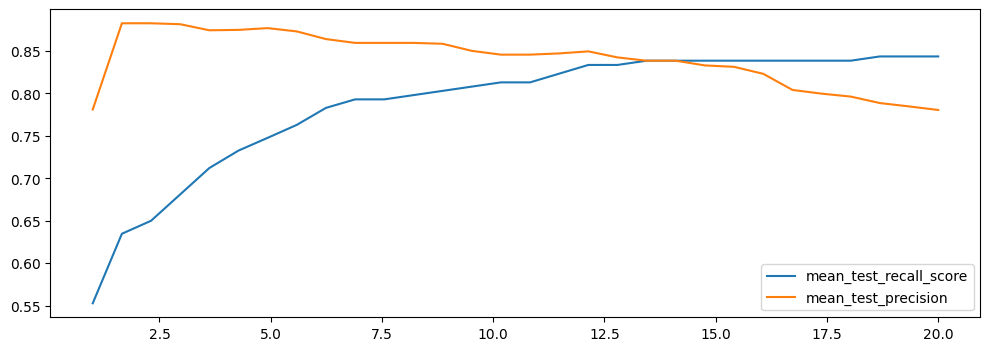

In [43]:
plt.figure(figsize=(12, 4))
df = pd.DataFrame(grid.cv_results_)
for score in ["mean_test_recall_score", "mean_test_precision"]:
    plt.plot([_[1] for _ in df["param_class_weight"]],
             df[score],
             label=score)
plt.legend();
# We can see that if we want to have a good precision we have to have a weight for v of around 1.75
# We can see that if we want to have a good rercall we have to have a weight for v of around 20.0
# We can see that if we want to have a balance between precision and recall, the weight for v should be around 13.75

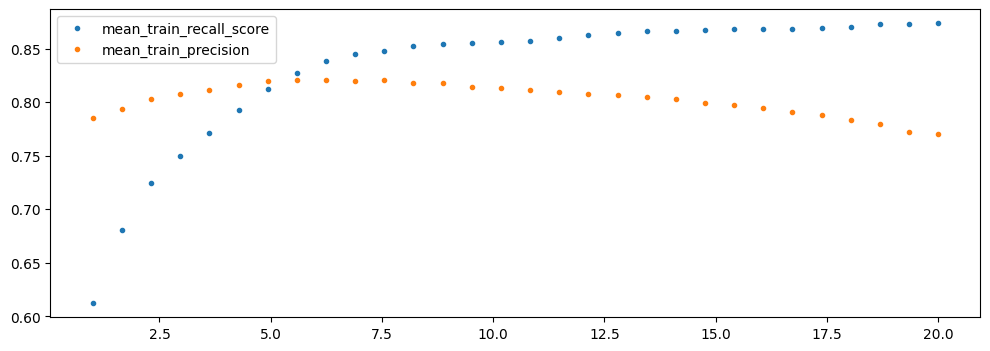

In [49]:
plt.figure(figsize=(12, 4))
df = pd.DataFrame(grid.cv_results_)
for score in ["mean_train_recall_score", "mean_train_precision"]:
    plt.plot([_[1] for _ in df["param_class_weight"]],
             df[score.replace("test", "train")],
             '.', label=score)
plt.legend()
# We can see that for our train set, we get completely different results (we should have a v of around 5 if we want to have a balance between precision and recall). So, it's a good reminder that cross validating results is a good idea.

In [50]:
# Since we have 2 metrics, scikit-learn is able to optimize either of them. However, suppose we want to have a balance between the 2. We can choose the f1 score. 
# But, it might be interesting to make our own metric (for example, selecting the minimum between our recall and precision score).

def min_recall_precision(y_true, y_pred): # same format as precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)
# Now, let's add this function to our grid search

In [51]:
# Lets add precision and recall to the grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={"class_weight": [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},  # This will give us a heigher resolution on the effects of the class weight, and by setting the value of `v` higher, we are telling the algorithm to focus of the fraud cases.
    scoring={"precision": make_scorer(precision_score), 
             "recall_score": make_scorer(recall_score), 
             "min_both": make_scorer(min_recall_precision)},  # If we want to use precision_score and recall_score inside the grid search, we should pass them to the make_scorer function first. Check next line.
    refit="min_both",  # Telling the grid search to refit on min_both
    return_train_score=True,  # It's nice to see the score for the train set as well
    cv = 10,  # Having more cross validation will take more time, but will result in more accurate metrics
    n_jobs= -1  # allows for the grid search to occur in parallel (using the difference PC cores)
)
grid.fit(X, y)



GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827

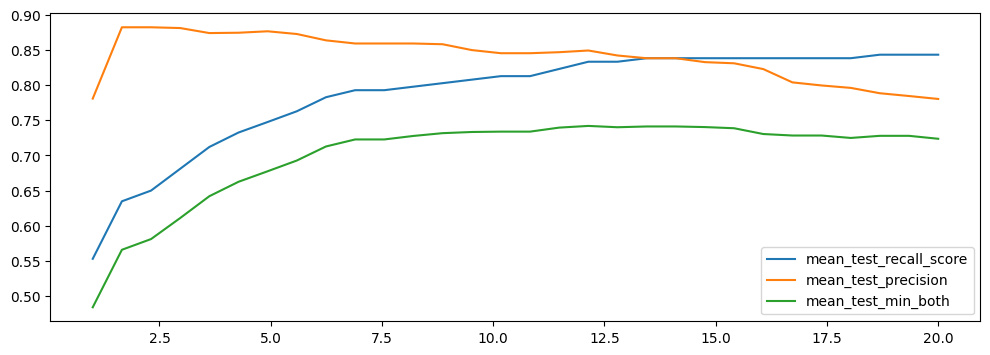

In [55]:
plt.figure(figsize=(12, 4))
df = pd.DataFrame(grid.cv_results_)
for score in ["mean_test_recall_score", "mean_test_precision", "mean_test_min_both"]:
    plt.plot([_[1] for _ in df["param_class_weight"]],
             df[score],
             label=score)
plt.legend();
# If we plot the result with the previous results for the recall and precision, we can see that the grid search picks a model for  12.5 <= v <= 16. Which makes sense because it's close to where the 2 values are balanced. 
# But, we can see that the score is lower than the score of the recall and precision.

In [56]:
# Why are we using make_scorer() function to pass the metrics ? 
s = make_scorer(min_recall_precision)
??s
# This function takes a metric and transform it into a _PredictScorer object which has the following signature: (estimator, X, y_true, sample_weight=None)
# One way of looking at this is that we start with a metric function: func(y_true, y_predict), then make_scorer() is turning the function into a callable object where I can pass it the following: (estimator, X, y_true, sample_weight).
# The idea is that sometimes we want to directly use the metric function as func(y_true, y_predict) and calling it directly can be useful. However, if we want to use it in a GridSearch, we have to re-write it in a way to make the GridSearch able to use it. 
# For this reason, we can pass the metric function to make_scorer and it will convert the metric function to an object that is usable directly by the GridSearch.

Signature:      s(estimator, X, y_true, sample_weight=None)
Type:           _PredictScorer
String form:    make_scorer(min_recall_precision)
File:           c:\users\elie\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py
Source:        
class _PredictScorer(_BaseScorer):
    def _score(self, method_caller, estimator, X, y_true, sample_weight=None):
        """Evaluate predicted target values for X relative to y_true.

        Parameters
        ----------
        method_caller : callable
            Returns predictions given an estimator, method name, and other
            arguments, potentially caching results.

        estimator : object
            Trained estimator to use for scoring. Must have a predict_proba
            method; the output of that is used to compute the score.

        X : array-like or sparse matrix
            Test data that will be fed to estimator.predict.

        y_true : array-like
            Gold standard target values fo

In [63]:
def min_recall_precision(est, X, y_true, sample_weight=None): # same format as precision_score(y_true, y_pred)
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

# Now, let's add this function to our grid search without using make_scorer
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={"class_weight": [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},  # This will give us a heigher resolution on the effects of the class weight, and by setting the value of `v` higher, we are telling the algorithm to focus of the fraud cases.
    scoring={"precision": make_scorer(precision_score), 
             "recall_score": make_scorer(recall_score), 
             "min_both": min_recall_precision},  # If we want to use precision_score and recall_score inside the grid search, we should pass them to the make_scorer function first. Check next line.
    refit="min_both",  # Telling the grid search to refit on min_both
    return_train_score=True,  # It's nice to see the score for the train set as well
    cv = 10,  # Having more cross validation will take more time, but will result in more accurate metrics
    n_jobs= -1  # allows for the grid search to occur in parallel (using the difference PC cores)
)
grid.fit(X, y, sample_weight=np.log(1+df["Amount"]))  # We added a sample weight to give more importance to fraud cases with high transactions.
# We took the log of the amount for numerical stability. So, now if we have a very large value for a transaction amount, we make sure that we are not overfitting on it.

KeyboardInterrupt: 

In [61]:
# Now, let's see the effect that the added sample_weight has made
plt.figure(figsize=(12, 4))
df = pd.DataFrame(grid.cv_results_)
for score in ["mean_test_recall_score", "mean_test_precision", "mean_test_min_both"]:
    plt.plot([_[1] for _ in df["param_class_weight"]],
             df[score],
             label=score)
plt.legend();
# We can see that adding sample_weight does influence the algorithm. Howevever, it's good to know that we can also use the sample_weight to our metric if we wanted to.

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'params', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision',
       'split5_test_precision', 'split6_test_precision',
       'split7_test_precision', 'split8_test_precision',
       'split9_test_precision', 'mean_test_precision', 'std_test_precision',
       'rank_test_precision', 'split0_train_precision',
       'split1_train_precision', 'split2_train_precision',
       'split3_train_precision', 'split4_train_precision',
       'split5_train_precision', 'split6_train_precision',
       'split7_train_precision', 'split8_train_precision',
       'split9_train_precision', 'mean_train_precision', 'std_train_precision',
       'split0_test_recall_score', 'split1_test_recall_score',
       'split2_test_recall_score', 'split3_test_recall_score',
       'split4_test_recall_score', 'split5_test_recall_s

In [66]:
# Let's consider a new approach to our problem. We can consider that fraud is like an outlier. It's a rare event but it's also something out of the ordinary.
# So, while we can have a classifier (0 or 1) to predict if a transaction is a fraud, But, if we just have an outlier detection algorithm, we can also relate it to fraud.
# Let's replace the LogisticsRegressor with an outlier detector an adapt the metrics such that we can check if this is the case

from collections import Counter
from sklearn.ensemble import IsolationForest

mod = IsolationForest().fit(X)  # since this is an outlier detection algorithm, it doesn't need a label. It just needs a dataset.
# Counter(mod.predict(X))  # scikit-learn assumes that 1 is not an outlier while -1 does represent an outlier.
np.where(mod.predict(X) == -1, 1, 0)  # Let's translate the outlier predictions (having 1 as a label for fraud and 0 otherwise)

array([0, 0, 0, ..., 0, 0, 0])

In [67]:
# If we pass an IsolationForest model to out GridSearch, the GridSearch will not work, since our score metrics (make_scorer(precision_score) and make_scorer(recall_score)) expect a 0 or a 1, not -1.
# So, let's write our own function

def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds==-1, 1, 0))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds==-1, 1, 0))

# Now, let's add these functions to our grid search
grid = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={"contamination": np.linspace(0.001, 0.02, 10)},  # we put in the contamination factor as a hyper parameter that we want to tune (it's a parameter that we want to optimize)
    scoring={"precision": outlier_precision,
             "recall_score": outlier_recall}, 
    refit="precision", 
    cv = 5,
    n_jobs= -1 
)
grid.fit(X, y);  # Notice that before, when we trained an IsolationForesst, we called it via .fit(X) (with a y label). 
# But, since we are passing the y label here anyway, we are able to use them in our own custom metrics (outlier_precision(mod, X, **y**) and outlier_recall(mod, X, **y**))
# This is something very flexible since this allows us to use outlier detection algorithms as if they were classifiers.

In [ ]:
# Now, let's see the results
plt.figure(figsize=(12, 4))
df = pd.DataFrame(grid.cv_results_)
for score in ["mean_test_recall_score", "mean_test_precision"]:
    plt.plot([_[1] for _ in df["param_contamination"]],  # This is out hyper parameters on the X-axis
             df[score],  # These are our scores on the Y axis
             label=score)
plt.legend();
# We can see that the outlier detection algorithm does not perform as well as a LogisticRegression in this case
# What is amazing here is that we are able to use metrics to quickly judge if an outlier model will be useful in this classification problem. 